# Optvier - Trading at close

## Introduction

First we should thanks optiver for holding this competition for Data science/Quant community. The aim of this notebook is to *predict* the closing price of stocks. The reason of predicting the closing prices is that there is an evidence of large amount of trades are made in last ten minutes before the close of the market. Hence, closing prices can be served as an indicator for traders to evaluate the stocks. 


## Background of Closing Auction (HK for example) 


## Work Flow of this notebook 
There are several thing I would like to achieve in this notebook. The first is a simple elementart data analysis (EDA) of the stock data. There are some features which deserve an attention such as the `imbalance volume`, `ask/bid size`, and `axsk/bid price`, which are the essential features to make an `order book`. Secondly, based on the EDA, the next step is feature engineering, buyt I would say `feature reverse-engineering`. There are lots of notebook availables in the competitions and it's good to `reverse engineer` the mindset of building those features and then try to build by our own. Once features engineering is done, we come to the model selection and training. I have to ideas in my mind: `transformer AE kind RNN` or `XGBoost`. They are the paradigms of time-series forecasting but I prefer XGBoost due to its simplicity. Finally, we will use the test set to make prediction and submit to the organization. To sum up, our work flow is: 
1. Data Preprocessing and Elementary Data Analysis
2. Features Engineering 
3. Model Selection [`XGBoost`]
4. Prediction and Submission


In [2]:
# Data Analytic Tools
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

# Computing Tools 
import lightgbm as lgb 
import xgboost as xgb 
import catboost as cbt 
import numpy as np 
import joblib 
import os

# Section 1: Data Preprocessing and Elementary Data Analysis

## Dataset Introduction 

- `stock_id` - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
- `date_id` - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
- `imbalance_size` - The amount unmatched at the current reference price (in USD).
- `imbalance_buy_sell_flag` - An indicator reflecting the direction of auction imbalance.
    * buy-side imbalance; 1
    * sell-side imbalance; -1
    * no imbalance; 0
- `reference_price` - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
- `matched_size` - The amount that can be matched at the current reference price (in USD).
- `far_price` - The crossing price that will maximize the number of shares matched based on auction - - - interest only. This calculation excludes continuous market orders.
- `near_price` - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
- `[bid/ask]_price` - Price of the most competitive buy/sell level in the non-auction book.
- `[bid/ask]_size` - The dollar notional amount on the most competitive buy/sell level in the non-auction book.
- `wap` - The weighted average price in the non-auction book.
$$
\frac{\text{Bid Price } \times \text{Ask Size}  +  \text{Ask Price } \times \text{Bid Size} }{ \text{Bid Size + Ask Size}}
$$
- `seconds_in_bucket` - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
- `target` - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
    * The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
    * The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
    * Where t is the time at the current observation, we can define the target:
        $$
        \text{Target} =  \Big( \frac{\text{Stock WAP}_{t + 60}}{\text{Stock WAP}_{t}} - \frac{\text{Index WAP}_{t+60} }{ \text{Index WAP}_t} \Big) * 10000
        $$
        All size related columns are in USD terms.


References:
- [High Frequency Trading II: Limit Order Book](https://www.quantstart.com/articles/high-frequency-trading-ii-limit-order-book/)


In [3]:
# load the train.csv file using pandas build in function 
train = pd.read_csv('train.csv')

# Print the first five value row of the dataset 
train.head()

# Print out the nan/ null values counts in each features
train.isnull().sum()

# Drop the nan/null values in the target since it would help for the inference 
# trian = train.dropna(subset=['target'])

# Drop the index inplace 
train.reset_index(drop=True, inplace=True)

In [4]:
train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


# 1.1 Data Preprocessing with Numba/JIT

In this subsession, we will preprocess the data and try to optimize the memory usages. One trick is to convert the data type in order to reduce the memory. 

# 1.2 Elemetary Data Analysis

In this subsession, we are going to inverstigate the the relation between each prices and sizes. Instead of tracking all stocks at all time, we examine the `stock[id==0]` and `date_id <= 5` as the exmaple notebook of Optiver. The reason of choosing `5 days` is that previously I picked `date_id ==0` but I could not see any negative imbalance. 

### Major Findings????
- ~~[Iceberg Order? (short review in Chinese)](https://www.zhihu.com/question/23667442): In some moments, either the bid/ask sizes are several orders higher.~~




Reference Notebooks:
- [Introduction and Explore Data Analysis](https://www.kaggle.com/code/chiangken/introduction-and-explore-data-analysis)
- [Optiver 2023 | EDA | PyTorch: LSTM-Attention Model](https://www.kaggle.com/code/aniketkolte04/optiver-2023-eda-pytorch-lstm-attention-model)
- [Optiver Trading at Close Intro.](https://www.kaggle.com/code/tomforbes/optiver-trading-at-the-close-introduction)

In [5]:
# define the df of stock00: 

stock00 = train.query('stock_id ==0 & date_id <100')
stock00

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066290,0,99,500,0.00,0,1.001294,24273741.15,1.001294,1.001294,1.001080,20176.56,1.001294,8782.42,1.001229,3.199577,5495,99_500_0
1066487,0,99,510,0.00,0,1.001402,24273741.15,1.001402,1.001402,1.001187,186.84,1.001402,76714.24,1.001188,2.419949,5496,99_510_0
1066684,0,99,520,0.00,0,1.001402,24273741.15,1.001402,1.001402,1.001080,33160.55,1.001402,68304.64,1.001185,3.550053,5497,99_520_0
1066881,0,99,530,0.00,0,1.001509,24273741.15,1.001509,1.001509,1.001402,373.76,1.001509,41585.25,1.001403,0.220537,5498,99_530_0


Text(0.5, 1.0, 'Overview for Ask/Bid Price and WAP')

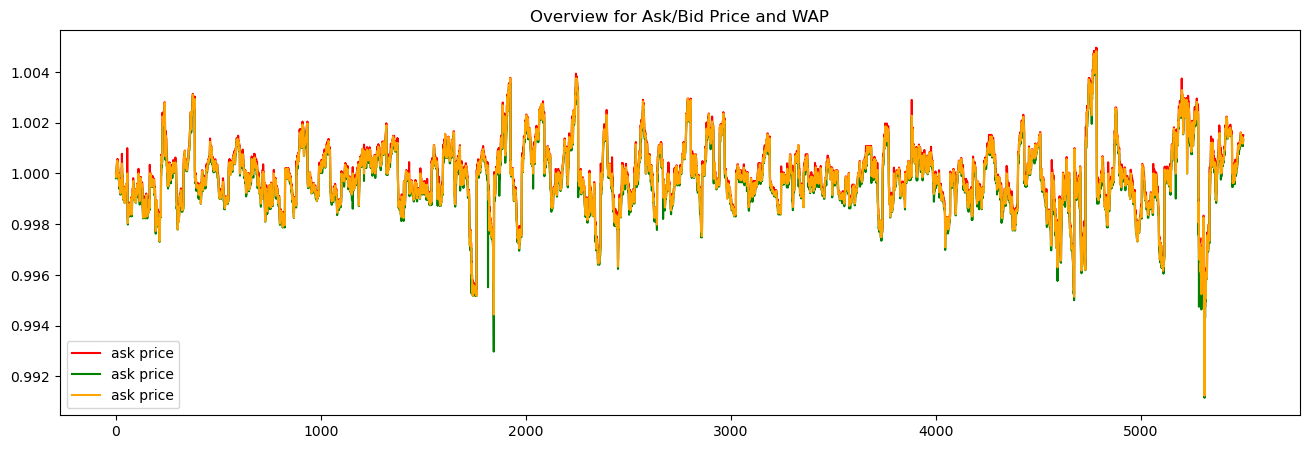

In [13]:
# PLot the Prices changes of stock 0 at date 0 
plt.figure(figsize=(16,5) )

plt.plot( stock00['time_id'], 
            stock00['ask_price'],
            label='ask price', 
            color= 'red' )


plt.plot( stock00['time_id'], 
            stock00['bid_price'],
            label='ask price', 
            color= 'green' )

plt.plot( stock00['time_id'], 
            stock00['wap'],
            label='ask price', 
            color= 'orange' )


plt.legend()
plt.title('Overview for Ask/Bid Price and WAP')


Text(0.5, 1.0, 'Overview for Normalized Ask/Bid Sizes Comparison for 5 days (WHy large ask Size')

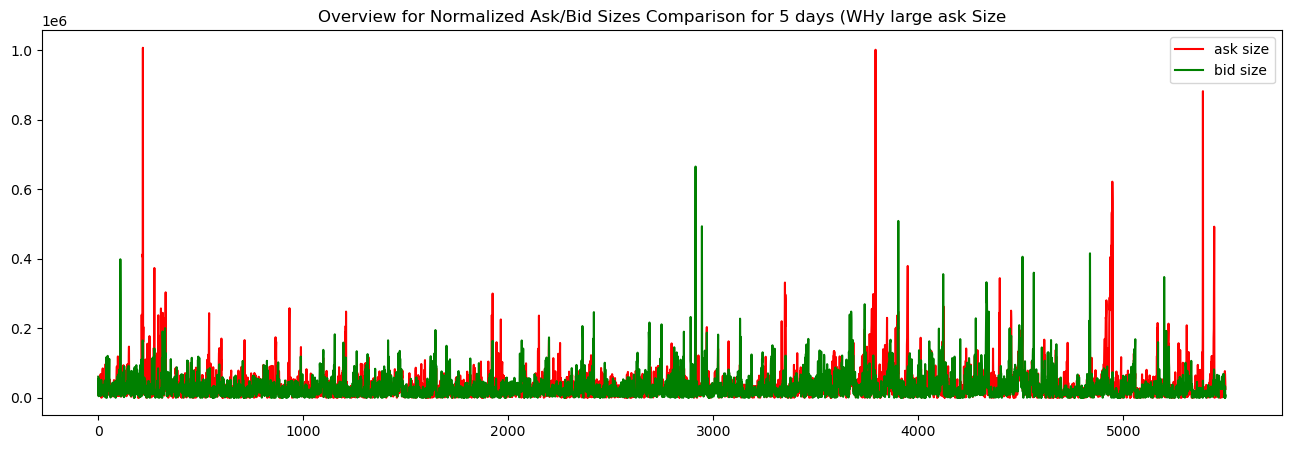

In [14]:
# Examine the volume changes 
# PLot the Prices changes of stock 0 at date 0 
plt.figure( 
    figsize=(16,5),
)

plt.plot( stock00['time_id'], 
            stock00['ask_size'],
            label='ask size', 
            color= 'red' )

plt.plot( stock00['time_id'], 
            stock00['bid_size'],
            label='bid size', 
            color= 'green' )

plt.legend()
plt.title(r'Overview for Normalized Ask/Bid Sizes Comparison for 5 days (WHy large ask Size')


Text(0.5, 1.0, 'Overview for Normalized Ask/Bid Sizes and target for X days')

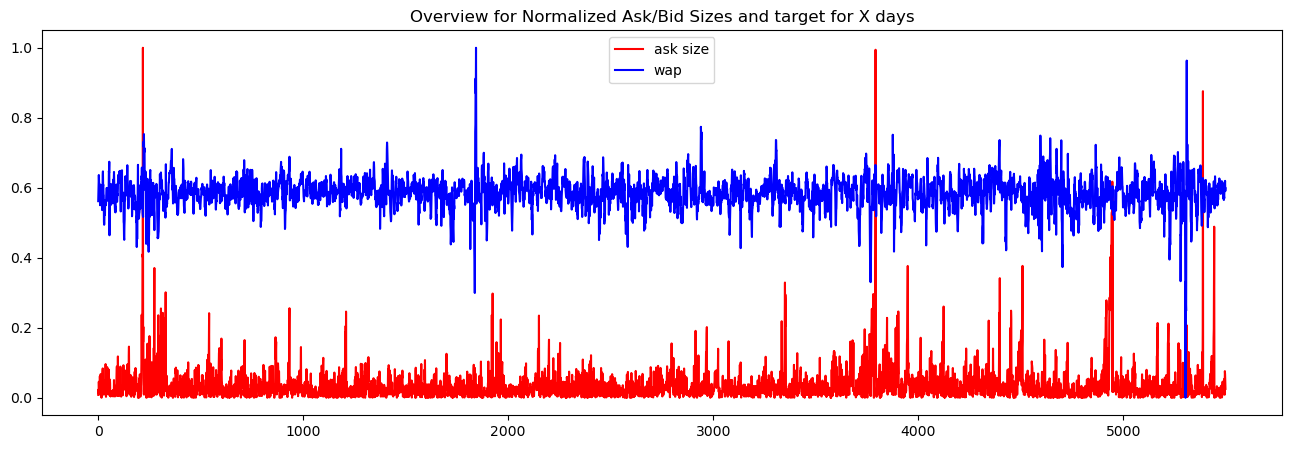

In [24]:
# Examine the volume changes 
# PLot the Prices changes of stock 0 at date 0 
plt.figure(
    figsize=(16,5), 
)


# Normalized the DataFrame for visualization
def normalize_df(df): 
    return (df - df.min()) \
        / (df.max() - df.min())


plt.plot( stock00['time_id'], 
            normalize_df(stock00['ask_size']),
            label='ask size', 
            color= 'red' )



plt.plot( stock00['time_id'], 
            normalize_df(stock00['target']),
            label='wap', 
            color= 'blue' )

plt.legend()
plt.title('Overview for Normalized Ask/Bid Sizes and target for X days')




Text(0.5, 0.98, 'Ask/Bid Sizes VS Target price')

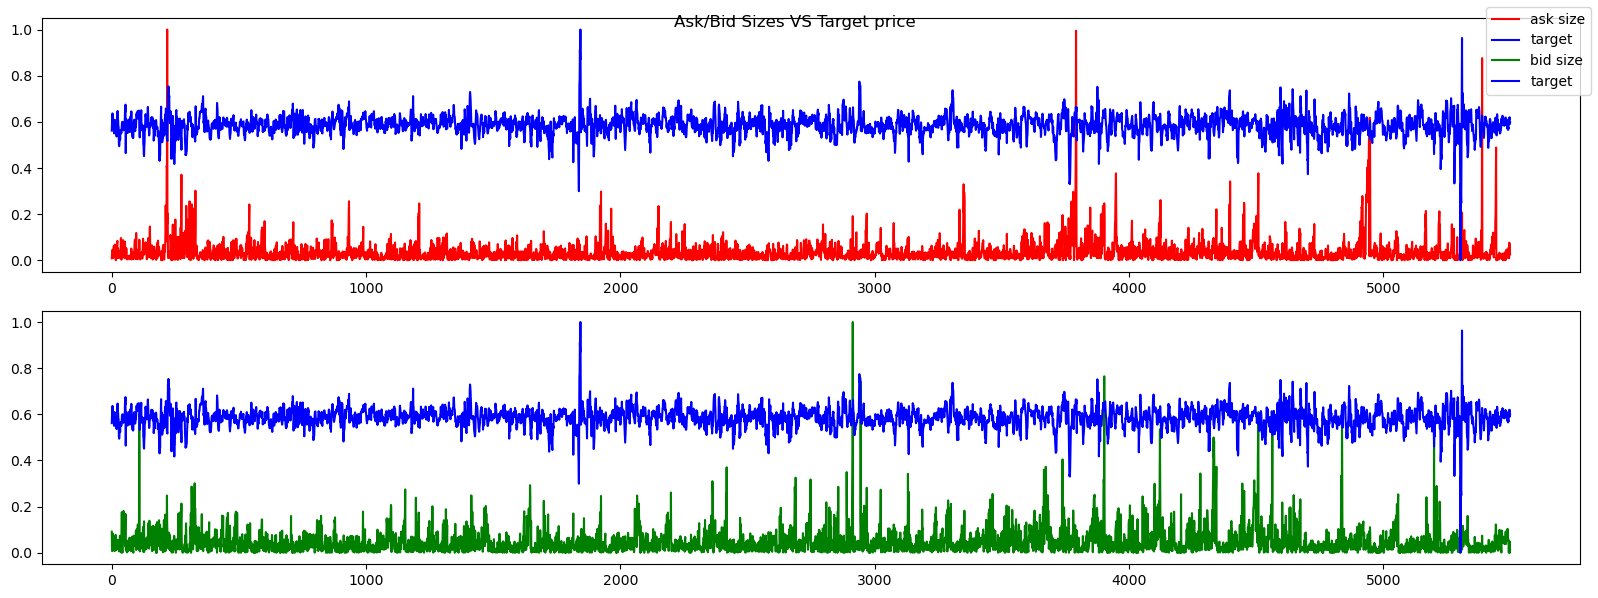

In [29]:
# Create the figure and axes with a (2,1) layout
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))

# Plot data on the first subplot
axes[0].plot( stock00['time_id'], 
            normalize_df(stock00['ask_size']),
            label='ask size', 
            color= 'red' )
axes[0].plot( stock00['time_id'], 
            normalize_df(stock00['target']),
            label='target', 
            color= 'blue' )


# Plot data on the second subplot
# Plot data on the first subplot
axes[1].plot( stock00['time_id'], 
            normalize_df(stock00['bid_size']),
            label='bid size', 
            color= 'green' )
axes[1].plot( stock00['time_id'], 
            normalize_df(stock00['target']),
            label='target', 
            color= 'blue' )

fig.legend()
fig.tight_layout()
fig.suptitle(r'Ask/Bid Sizes VS Target price')

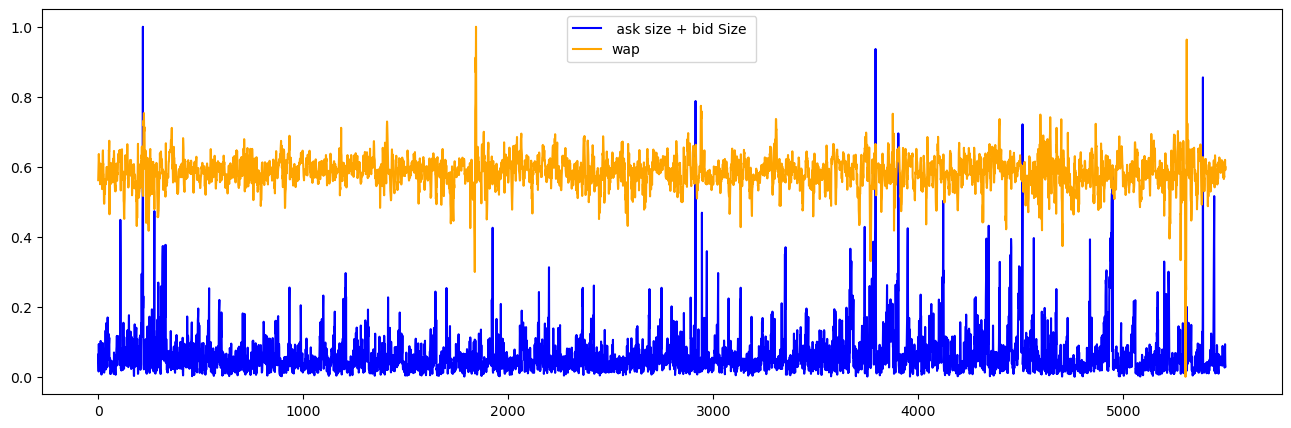

In [23]:
# Examine the volume changes 
# PLot the Prices changes of stock 0 at date 0 

total_size = stock00.eval('ask_size + bid_size').values


plt.figure(
    figsize=(16,5),
)


plt.plot( stock00['time_id'], 
            normalize_df(total_size),
            label=' ask size + bid Size ', 
            color= 'blue' )


plt.plot( stock00['time_id'], 
            normalize_df(stock00['target']),
            label='wap', 
            color= 'orange' )
plt.legend()

In [ ]:
# Now see the 5 stocks in 5 days 
stock05 = train.query('stock_id <= 5 & date_id <5')

In [ ]:
stock05.head()

In [ ]:
# Group stock05 by their id 
stock05_0 = stock05[stock05["stock_id"] ==0]
stock05_1 = stock05[stock05["stock_id"] ==1]
stock05_2 = stock05[stock05["stock_id"] ==2]
stock05_3 = stock05[stock05["stock_id"] ==3]
stock05_4 = stock05[stock05["stock_id"] ==4]


fig.add_trace(
    go.Scatter(x = stock00['time_id'], 
            y = (stock05_0['wap'] - stock05_0['wap'].min()) \
               / (stock05_0['wap'].max() - stock05_0['wap'].min()), 
            name = 'WAP_0',
            line = dict(color = 'red')))


fig.add_trace(
    go.Scatter(x = stock00['time_id'], 
            y = (stock05_1['wap'] - stock05_1['wap'].min()) \
               / (stock05_1['wap'].max() - stock05_1['wap'].min()), 
            name = 'WAP_1',
            line = dict(color = 'green')))


fig.add_trace(
    go.Scatter(x = stock00['time_id'], 
            y = (stock05_2['wap'] - stock05_2['wap'].min()) \
               / (stock05_2['wap'].max() - stock05_2['wap'].min()), 
            name = 'WAP_2',
            line = dict(color = 'blue')))



In [ ]:

ts1 = stock05_0['wap'].values
ts2 = stock05_4['wap'].values

# Create a DataFrame from the time series
df = pd.DataFrame({'Series 1': ts1, 'Series 2': ts2})

# Calculate the correlation coefficient using the corr() function
correlation_coefficient = df['Series 1'].corr(df['Series 2'])
correlation_coefficient

In [ ]:
subset = train.query('time_id <=100')
subset.head()

In [ ]:
train['stock_id'].unique()[:-10]

In [ ]:
five_day_dict = { }

for i in train['stock_id'].unique()[:70]:
    five_day_dict[f'stock{i}'] = train.query(f'stock_id == {i} & date_id < 300')['wap'].to_numpy()


In [ ]:
length = []
for i in train['stock_id'].unique()[:70]: 
    length.append(len( five_day_dict[f'stock{i}']))


In [ ]:
five_day_df = pd.DataFrame(five_day_dict)
five_day_df

In [ ]:
corr= five_day_df.corr()
corr.head()

In [ ]:
corr_val = corr.values
corr_val

In [ ]:
x, y = np.where( (abs(np.tril(corr_val)) > 0.5) & ( np.tril(corr_val) != 1) )
x,y

In [ ]:
len(x)

# Section 2: Feature Engineering

## List of wanted featurs❤️
- Liquidity: The ability to be bought or sold quickly and easily (fight with Iceburg order) 
- Drift / Variance in GBM 
- Iceburg Orders 
- Correlation of among stocks properties (e.g. WAP, size, target...) 
    * Seems No Target correlation as number of date increases
    * WAP correlation seems more 
* bid-ask spread / midpoint: $(\text{bid prive} + \text{ask price})/ 2$ for liquidity
* Difference between bid/ask size: If there is large amount of stock is bought/sold -> stocks prices increase/falls 
    * 




## Section 2.1: Inspiration from Geometric Brownian Motion (GBM)
Since there are no right answers of which features should be built. Therefore, based on some intuition I will make several features for example. Before going to the detail, lets see an equation which is the `Geometric Brownian motion` in differential form

$$
dS(t) = \mu S(t) dt + \sigma S(t) dW(t) \Leftrightarrow  S(t) = S_0 \exp \Big( (\mu - \frac{\sigma^2}{2}) t + \sigma W_t \Big ) 
$$

where $\mu, \sigma$, and $W(t)$ is the drift, volatility, and the standard Brownian motion. From CgatGPT, it gives us more concrete explanation on these variables:

- $\mu$ represents the drift component, which is the average or expected growth rate.
- $\sigma$ represents the volatility component, which measures the standard deviation of the variable's returns.
- $S(t)$ represents the value of the variable at time $t$, usually it refers to the stock price

For the Brownian motion $W(t)$, we can think of it as an continuous version of Binomial model, we either winning or losing 1 dolalr. Therefore, we can write down the discrete form of Brownian motion $W(t)$: 

$$
W = X_1 + X_2 + \cdots + X_n ,~ X \in \{-1 ,1 \}  \sim  Bern(p) 
$$

By linearity of expectation and Central Limit Theorem (CLT), we can show that $W \sim \mathcal{N}(0, \text{some mean}) $, where $\mathbb{E} W = 0 $ for $p = 0.5$ (equal chance of winning or losing). Therefore, there is no way to win any money in long term. 


# Section 2.? Create Featured Dataset 


Reference Notebooks:
- [🥇🥇baseline lgb, xgb and catboost🥇🥇](https://www.kaggle.com/code/yuanzhezhou/baseline-lgb-xgb-and-catboost)
- [Explained singel model⚡Optiver ](https://www.kaggle.com/code/zulqarnainali/explained-singel-model-optiver)

In [ ]:
# Define features for later use 

# 🏎️ Import Numba for just-in-time (JIT) compilation and parallel processing
from numba import njit, prange

# use Numba decorator for parallel computing
@njit(parallel=True)
def features1():
    pass 



In [ ]:

def generate_features(df: pd.DataFrame) -> pd.DataFrame:
    features = ['seconds_in_bucket', 'imbalance_buy_sell_flag',
               'imbalance_size', 'matched_size', 'bid_size', 'ask_size',
                'reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap',
                'imb_s1', 'imb_s2'
               ]
    
    df['imb_s1'] = df.eval('(bid_size-ask_size)/(bid_size+ask_size)')
    df['imb_s2'] = df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')
    
    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']

    
    return df[features]
    

# Section 3: Model Selection CatBoost

In [ ]:
# TRAINING = True
# if TRAINING:
# #    df_train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
#    df_ = generate_features(train)

In [ ]:
TRAINING = True
if TRAINING:
   df_ = generate_features(train)

In [ ]:
model_path ='/kaggle/input/RKCP0219'
os.makedirs('models', exist_ok=True)

N_fold = 5

if TRAINING:
    X = df_.values
    Y = train['target'].values

    X = X[np.isfinite(Y)]
    Y = Y[np.isfinite(Y)]

    index = np.arange(len(X))

In [ ]:
models = []

def train(model_dict, modelname='lgb'):
    if TRAINING:
        model = model_dict[modelname]
        model.fit(X[index%N_fold!=i], Y[index%N_fold!=i], 
                    eval_set=[(X[index%N_fold==i], Y[index%N_fold==i])], 
                    verbose=10, 
                    early_stopping_rounds=100
                    )
        models.append(model)
        joblib.dump(model, './models/{modelname}_{i}.model')
    else:
        models.append(joblib.load(f'{model_path}/{modelname}_{i}.model'))
    return 

model_dict = {
    'cbt': cbt.CatBoostRegressor(objective='MAE', iterations=10),

}

for i in range(N_fold):
    train(model_dict, 'cbt')

In [ ]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [ ]:
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    feat = generate_features(test)
    
    sample_prediction['target'] = np.mean([model.predict(feat) for model in models], 0)
    env.predict(sample_prediction)
    counter += 1